In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats
import re # For more complex string operations if needed

# Set up plot display in notebook
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')


In [2]:
# Load data from files
transaction_data_raw = pd.ExcelFile("QVI_transaction_data.xlsx")
customer_data = pd.read_csv('QVI_purchase_behaviour.csv')

# Create a copy for manipulation, keeping the original data intact
transaction_data = transaction_data_raw.parse('in')


In [3]:
print("--- Initial transaction data information ---")
transaction_data.info()


--- Initial transaction data information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


In [4]:
print("--- First 5 rows of transaction data ---")
transaction_data.head()


--- First 5 rows of transaction data ---


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [5]:
print("--- Initial customer data information ---")
customer_data.info()


--- Initial customer data information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [6]:
print("--- First 5 rows of customer data ---")
customer_data.head()


--- First 5 rows of customer data ---


,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [7]:
print("--- Converting DATE column ---")
# Convert DATE column to datetime format
transaction_data['DATE'] = pd.to_datetime(transaction_data['DATE'], origin='1899-12-30', unit='D')
print(f"Data type of DATE column after conversion: {transaction_data['DATE'].dtype}")
transaction_data['DATE'].head()


--- Converting DATE column ---
Data type of DATE column after conversion: datetime64[ns]


0   2018-10-17
1   2019-05-14
2   2019-05-20
3   2018-08-17
4   2018-08-18
Name: DATE, dtype: datetime64[ns]

In [8]:
print("--- Analyzing PROD_NAME ---")
# Check unique product names
print("Some product names and their counts:")
transaction_data['PROD_NAME'].value_counts().head()


--- Analyzing PROD_NAME ---
Some product names and their counts:


PROD_NAME
Kettle Mozzarella   Basil & Pesto 175g      3304
Kettle Tortilla ChpsHny&Jlpno Chili 150g    3296
Cobs Popd Swt/Chlli &Sr/Cream Chips 110g    3269
Tyrrells Crisps     Ched & Chives 165g      3268
Cobs Popd Sea Salt  Chips 110g              3265
Name: count, dtype: int64

In [9]:
# Text analysis (word exploration in product names)
all_prod_words = transaction_data['PROD_NAME'].str.findall(r'\b\w+\b').explode().str.lower()
word_counts = all_prod_words.value_counts()
print("Most common words in product names:")
word_counts.head(10)


Most common words in product names:


PROD_NAME
175g        60561
chips       49770
150g        43131
kettle      41288
smiths      28860
salt        27976
cheese      27890
pringles    25102
134g        25102
doritos     24962
Name: count, dtype: int64

In [10]:
# Remove Salsa products
salsa_mask = transaction_data['PROD_NAME'].str.lower().str.contains('salsa', na=False)
print(f"Number of salsa products found: {salsa_mask.sum()}")
transaction_data = transaction_data[~salsa_mask].copy()
print(f"Number of transactions remaining after removing salsa: {len(transaction_data)}")


Number of salsa products found: 18094
Number of transactions remaining after removing salsa: 246742


In [11]:
print("--- Initial summary statistics (before PROD_QTY outlier handling) ---")
transaction_data.describe(include='all')


--- Initial summary statistics (before PROD_QTY outlier handling) ---


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
count,246742,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742,246742.000000,246742.000000
unique,NaN,NaN,NaN,NaN,NaN,105,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,Kettle Mozzarella Basil & Pesto 175g,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,3304,NaN,NaN
mean,2018-12-30 01:19:01.211467520,135.051098,1.355310e+05,1.351311e+05,56.351789,NaN,1.908062,7.321322
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,NaN,1.000000,1.700000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756925e+04,26.000000,NaN,2.000000,5.800000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351830e+05,53.000000,NaN,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030840e+05,2.026538e+05,87.000000,NaN,2.000000,8.800000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,NaN,200.000000,650.000000


In [12]:
# Investigate PROD_QTY outliers
outlier_transactions_qty_200 = transaction_data[transaction_data['PROD_QTY'] == 200]
print("Transactions with PROD_QTY = 200:")
outlier_transactions_qty_200


Transactions with PROD_QTY = 200:


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [13]:
if not outlier_transactions_qty_200.empty:
    # Assume only one customer as in R documentation
    outlier_customer_id = 226000 # Based on R documentation
    customer_226000_transactions = transaction_data[transaction_data['LYLTY_CARD_NBR'] == outlier_customer_id]
    print(f"Transactions for customer LYLTY_CARD_NBR = {outlier_customer_id}:")
    customer_226000_transactions
    
    # Filter out outlier customer
    transaction_data = transaction_data[transaction_data['LYLTY_CARD_NBR'] != outlier_customer_id].copy()
    print(f"Number of transactions remaining after removing customer {outlier_customer_id}: {len(transaction_data)}")


Transactions for customer LYLTY_CARD_NBR = 226000:
Number of transactions remaining after removing customer 226000: 246740


In [14]:
print("--- Table 1: Summary Statistics of Transaction Data (After Outlier Removal) ---")
# Set datetime_is_numeric=True to include DATE column in statistics if supported by newer pandas versions
try:
    summary_stats_post_outlier = transaction_data.describe(include='all', datetime_is_numeric=True)
except TypeError: # For older pandas versions without datetime_is_numeric
    summary_stats_post_outlier = transaction_data.describe(include='all')
summary_stats_post_outlier


--- Table 1: Summary Statistics of Transaction Data (After Outlier Removal) ---


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
count,246740,246740.000000,2.467400e+05,2.467400e+05,246740.000000,246740,246740.000000,246740.000000
unique,NaN,NaN,NaN,NaN,NaN,105,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,Kettle Mozzarella Basil & Pesto 175g,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,3304,NaN,NaN
mean,2018-12-30 01:18:58.448569344,135.050361,1.355303e+05,1.351304e+05,56.352213,NaN,1.906456,7.316113
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,NaN,1.000000,1.700000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756875e+04,26.000000,NaN,2.000000,5.800000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351815e+05,53.000000,NaN,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030832e+05,2.026522e+05,87.000000,NaN,2.000000,8.800000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,NaN,5.000000,29.500000


In [15]:
print("--- Transaction trends over time ---")
# Count transactions by day
transactions_by_day_counts = transaction_data.groupby('DATE').size().reset_index(name='N')
print(f"Number of days with transactions: {len(transactions_by_day_counts)}")

# Identify and handle missing dates
all_dates_df = pd.DataFrame({'DATE': pd.date_range(start="2018-07-01", end="2019-06-30", freq='D')})
transactions_by_day_full = pd.merge(all_dates_df, transactions_by_day_counts, on='DATE', how='left').fillna({'N': 0})
missing_transaction_dates = transactions_by_day_full[transactions_by_day_full['N'] == 0]
print("\nDays with no transactions (e.g., Christmas):")
missing_transaction_dates.head()


--- Transaction trends over time ---
Number of days with transactions: 364

Days with no transactions (e.g., Christmas):


,DATE,N
177,2018-12-25,0.0


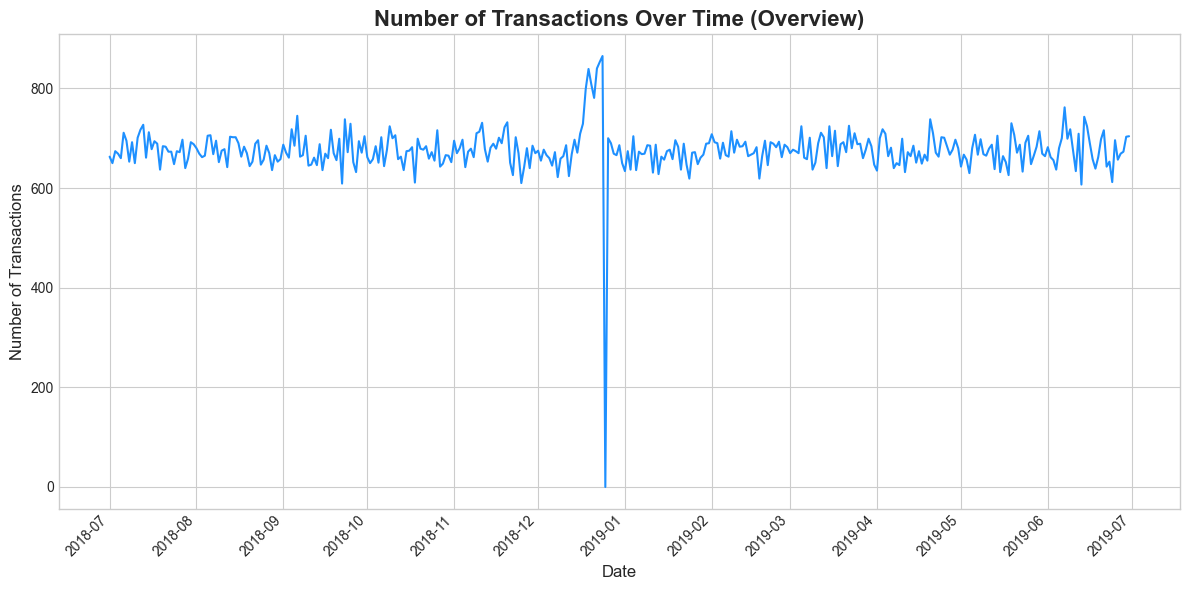

In [16]:
# Visualize transaction volume
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x='DATE', y='N', data=transactions_by_day_full, ax=ax, color='dodgerblue')
ax.set_title('Number of Transactions Over Time (Overview)', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Transactions', fontsize=12)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


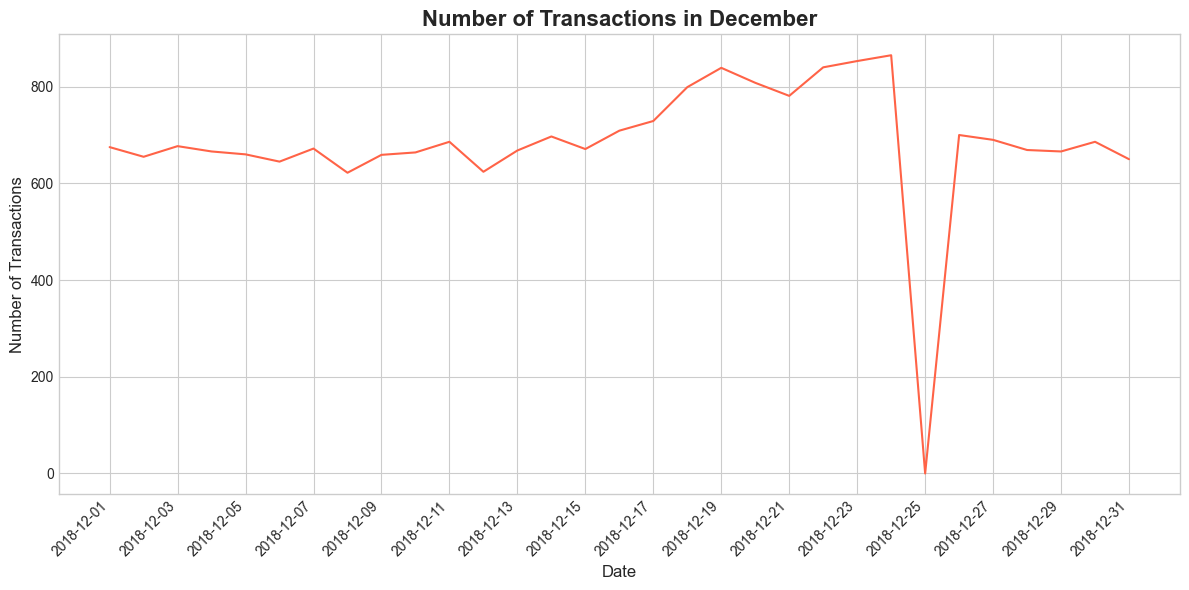

In [17]:
# Analyze December transactions
december_transactions = transactions_by_day_full[transactions_by_day_full['DATE'].dt.month == 12]
fig_dec, ax_dec = plt.subplots(figsize=(12, 6))
sns.lineplot(x='DATE', y='N', data=december_transactions, ax=ax_dec, color='tomato')
ax_dec.set_title('Number of Transactions in December', fontsize=16, fontweight='bold')
ax_dec.set_xlabel('Date', fontsize=12)
ax_dec.set_ylabel('Number of Transactions', fontsize=12)
ax_dec.xaxis.set_major_locator(mdates.DayLocator(interval=2)) # Display every 2 days
ax_dec.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


In [18]:
print("--- Feature engineering ---")
# Extract the last number in the product name, assuming it's the pack size
transaction_data['PACK_SIZE'] = transaction_data['PROD_NAME'].str.findall(r'\d+').str[-1]
# Handle cases where no number is found (rare with this data)
transaction_data['PACK_SIZE'] = pd.to_numeric(transaction_data['PACK_SIZE'], errors='coerce').fillna(0).astype(int)

print("A few examples of extracted PACK_SIZE:")
transaction_data['PACK_SIZE'].head()


--- Feature engineering ---
A few examples of extracted PACK_SIZE:


0    175
1    175
2    170
3    175
4    150
Name: PACK_SIZE, dtype: int64

In [19]:
pack_size_counts = transaction_data['PACK_SIZE'].value_counts().sort_index()
print("Distribution of PACK_SIZE:")
pack_size_counts


Distribution of PACK_SIZE:


PACK_SIZE
70      1507
90      3008
110    22387
125     1454
134    25102
135     3257
150    40203
160     2970
165    15297
170    19983
175    66390
180     1468
190     2995
200     4473
210     6272
220     1564
250     3169
270     6285
330    12540
380     6416
Name: count, dtype: int64

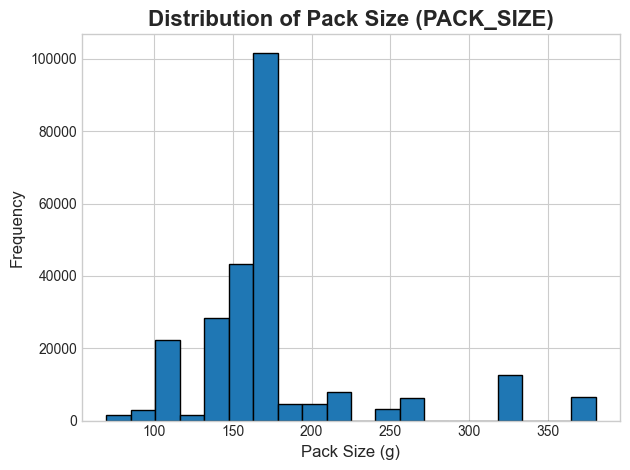

In [20]:
transaction_data['PACK_SIZE'].hist(bins=len(pack_size_counts) if len(pack_size_counts) < 50 else 50, edgecolor='black')
plt.title('Distribution of Pack Size (PACK_SIZE)', fontsize=16, fontweight='bold')
plt.xlabel('Pack Size (g)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()


In [21]:
# Extract initial brand (first word)
transaction_data['BRAND'] = transaction_data['PROD_NAME'].str.split().str[0].str.upper()

# Standardize brand names
brand_cleaning_map = {
    "RED": "RRD", "SNBTS": "SUNBITES", "INFZNS": "INFUZIONS",
    "WW": "WOOLWORTHS", "SMITH": "SMITHS", "NCC": "NATURAL",
    "DORITO": "DORITOS", "GRAIN": "GRNWVES", # GRNWVES could be Grain Waves
    "CC'S": "CCS" # Added CCS from R data
}
transaction_data['BRAND'] = transaction_data['BRAND'].replace(brand_cleaning_map)


In [22]:
print("--- Table 2: Cleaned Brand Distribution ---")
cleaned_brand_counts = transaction_data['BRAND'].value_counts().sort_index()
cleaned_brand_counts.reset_index().rename(columns={'index':'BRAND', 'BRAND':'Count'})


--- Table 2: Cleaned Brand Distribution ---


,Count,count
0,BURGER,1564
1,CCS,4551
2,CHEETOS,2927
3,CHEEZELS,4603
4,COBS,9693
5,DORITOS,25224
6,FRENCH,1418
7,GRNWVES,7740
8,INFUZIONS,14201
9,KETTLE,41288


In [23]:
print("--- Exploring customer data ---")
# Check Structure and Summary
print("Customer data information:")
customer_data.info()


--- Exploring customer data ---
Customer data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [24]:
print("Customer data summary statistics:")
customer_data.describe(include='all')


Customer data summary statistics:


,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
count,7.263700e+04,72637,72637
unique,NaN,7,3
top,NaN,RETIREES,Mainstream
freq,NaN,14805,29245
mean,1.361859e+05,NaN,NaN
std,8.989293e+04,NaN,NaN
min,1.000000e+03,NaN,NaN
25%,6.620200e+04,NaN,NaN
50%,1.340400e+05,NaN,NaN
75%,2.033750e+05,NaN,NaN


In [25]:
# Check Distribution of LIFESTAGE and PREMIUM_CUSTOMER
print("LIFESTAGE distribution:")
customer_data['LIFESTAGE'].value_counts()


LIFESTAGE distribution:


LIFESTAGE
RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9780
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: count, dtype: int64

In [26]:
print("PREMIUM_CUSTOMER distribution:")
customer_data['PREMIUM_CUSTOMER'].value_counts()


PREMIUM_CUSTOMER distribution:


PREMIUM_CUSTOMER
Mainstream    29245
Budget        24470
Premium       18922
Name: count, dtype: int64

In [27]:
print("--- Merging data ---")
# Perform Merge
merged_data = pd.merge(transaction_data, customer_data, on='LYLTY_CARD_NBR', how='left')
print(f"Number of rows in transaction data: {len(transaction_data)}")
print(f"Number of rows in merged data: {len(merged_data)}")


--- Merging data ---
Number of rows in transaction data: 246740
Number of rows in merged data: 246740


In [28]:
# Verify Integrity
null_lifestage_count = merged_data['LIFESTAGE'].isnull().sum()
null_premium_customer_count = merged_data['PREMIUM_CUSTOMER'].isnull().sum()
print(f"Number of null values in LIFESTAGE after merge: {null_lifestage_count}")
print(f"Number of null values in PREMIUM_CUSTOMER after merge: {null_premium_customer_count}")

if null_lifestage_count == 0 and null_premium_customer_count == 0:
    print("Merge successful, no transactions missing customer information.")
else:
    print("Warning: Some transactions are missing customer information after merge.")


Number of null values in LIFESTAGE after merge: 0
Number of null values in PREMIUM_CUSTOMER after merge: 0
Merge successful, no transactions missing customer information.


In [29]:
print("--- Customer segmentation analysis ---")
sales_by_segment = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'], observed=True)['TOT_SALES'].sum().reset_index(name='SALES')
print("--- Table 3: Total Sales by LIFESTAGE and PREMIUM_CUSTOMER (Top 10) ---")
sales_by_segment.sort_values(by='SALES', ascending=False).head(10)


--- Customer segmentation analysis ---
--- Table 3: Total Sales by LIFESTAGE and PREMIUM_CUSTOMER (Top 10) ---


,LIFESTAGE,PREMIUM_CUSTOMER,SALES
6,OLDER FAMILIES,Budget,156863.75
19,YOUNG SINGLES/COUPLES,Mainstream,147582.20
13,RETIREES,Mainstream,145168.95
15,YOUNG FAMILIES,Budget,129717.95
9,OLDER SINGLES/COUPLES,Budget,127833.60
10,OLDER SINGLES/COUPLES,Mainstream,124648.50
11,OLDER SINGLES/COUPLES,Premium,123537.55
12,RETIREES,Budget,105916.30
7,OLDER FAMILIES,Mainstream,96413.55
14,RETIREES,Premium,91296.65


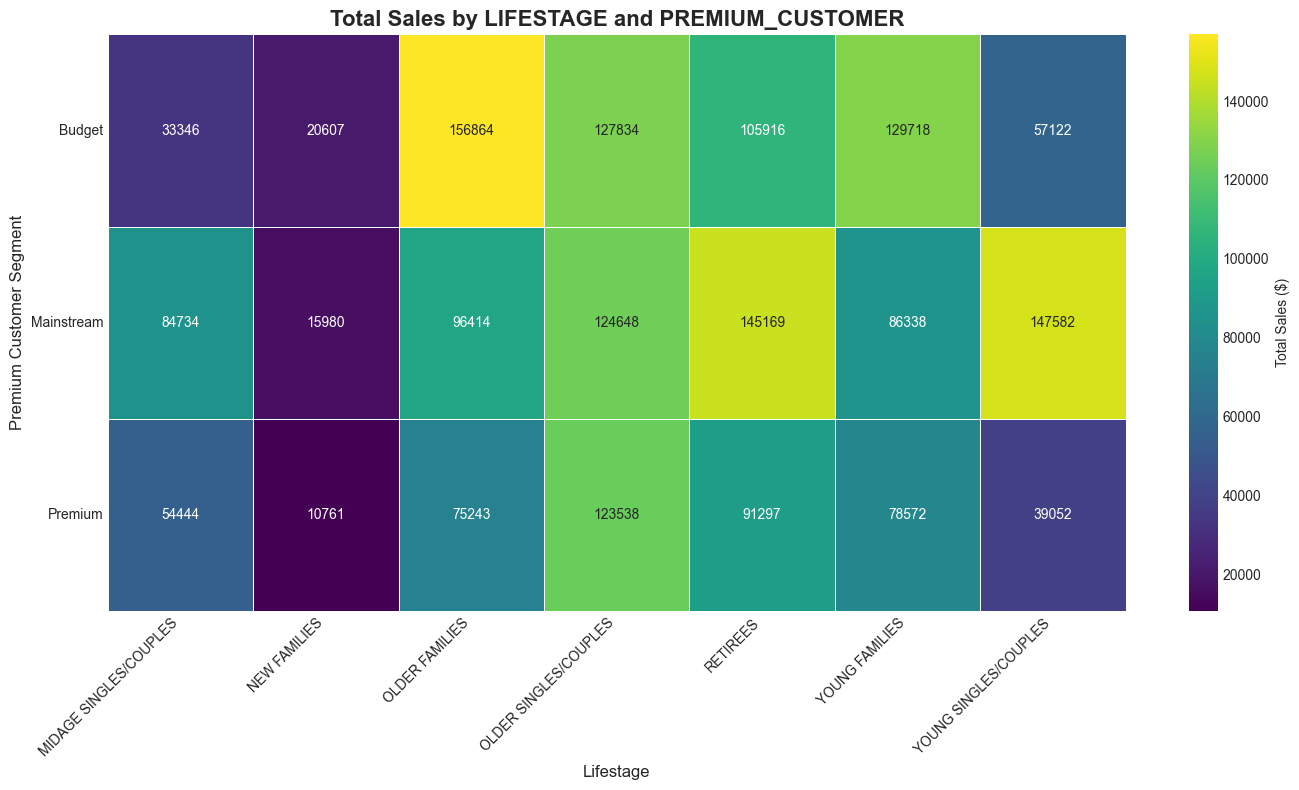

In [30]:
sales_pivot = sales_by_segment.pivot_table(index='PREMIUM_CUSTOMER', columns='LIFESTAGE', values='SALES')
plt.figure(figsize=(14, 8))
sns.heatmap(sales_pivot, annot=True, fmt=".0f", cmap="viridis", linewidths=.5,
            cbar_kws={'label': 'Total Sales ($)'})
plt.title('Total Sales by LIFESTAGE and PREMIUM_CUSTOMER', fontsize=16, fontweight='bold')
plt.ylabel('Premium Customer Segment', fontsize=12)
plt.xlabel('Lifestage', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()


In [31]:
num_customers_segment = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'], observed=True)['LYLTY_CARD_NBR'].nunique().reset_index(name='CUSTOMERS')
print("--- Table 4: Number of Customers by LIFESTAGE and PREMIUM_CUSTOMER (Top 10) ---")
num_customers_segment.sort_values(by='CUSTOMERS', ascending=False).head(10)


--- Table 4: Number of Customers by LIFESTAGE and PREMIUM_CUSTOMER (Top 10) ---


,LIFESTAGE,PREMIUM_CUSTOMER,CUSTOMERS
19,YOUNG SINGLES/COUPLES,Mainstream,7917
13,RETIREES,Mainstream,6358
10,OLDER SINGLES/COUPLES,Mainstream,4858
9,OLDER SINGLES/COUPLES,Budget,4849
11,OLDER SINGLES/COUPLES,Premium,4682
6,OLDER FAMILIES,Budget,4611
12,RETIREES,Budget,4385
15,YOUNG FAMILIES,Budget,3953
14,RETIREES,Premium,3812
18,YOUNG SINGLES/COUPLES,Budget,3647


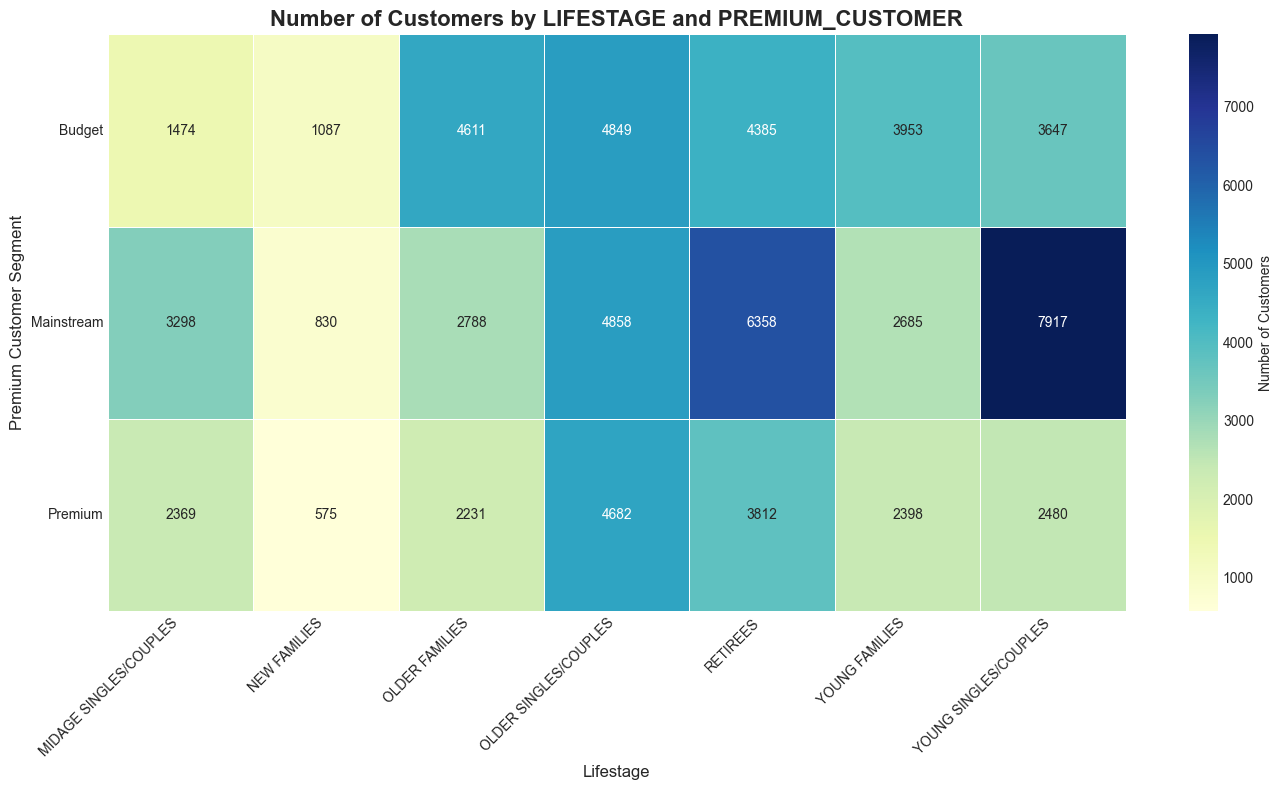

In [32]:
customers_pivot = num_customers_segment.pivot_table(index='PREMIUM_CUSTOMER', columns='LIFESTAGE', values='CUSTOMERS')
plt.figure(figsize=(14, 8))
sns.heatmap(customers_pivot, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=.5,
            cbar_kws={'label': 'Number of Customers'})
plt.title('Number of Customers by LIFESTAGE and PREMIUM_CUSTOMER', fontsize=16, fontweight='bold')
plt.ylabel('Premium Customer Segment', fontsize=12)
plt.xlabel('Lifestage', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()


In [33]:
avg_units_segment = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'], observed=True).agg(
    total_qty=('PROD_QTY', 'sum'),
    unique_customers=('LYLTY_CARD_NBR', 'nunique')
).reset_index()
avg_units_segment['AVG_UNITS_PER_CUSTOMER'] = avg_units_segment['total_qty'] / avg_units_segment['unique_customers']
print("--- Table 5: Average Units per Customer by Segment (Top 10) ---")
avg_units_segment.sort_values(by='AVG_UNITS_PER_CUSTOMER', ascending=False).head(10)


--- Table 5: Average Units per Customer by Segment (Top 10) ---


,LIFESTAGE,PREMIUM_CUSTOMER,total_qty,unique_customers,AVG_UNITS_PER_CUSTOMER
7,OLDER FAMILIES,Mainstream,25804,2788,9.255380
6,OLDER FAMILIES,Budget,41853,4611,9.076773
8,OLDER FAMILIES,Premium,20239,2231,9.071717
15,YOUNG FAMILIES,Budget,34482,3953,8.722995
17,YOUNG FAMILIES,Premium,20901,2398,8.716013
16,YOUNG FAMILIES,Mainstream,23194,2685,8.638361
9,OLDER SINGLES/COUPLES,Budget,32883,4849,6.781398
11,OLDER SINGLES/COUPLES,Premium,31695,4682,6.769543
10,OLDER SINGLES/COUPLES,Mainstream,32607,4858,6.712021
1,MIDAGE SINGLES/COUPLES,Mainstream,21213,3298,6.432080


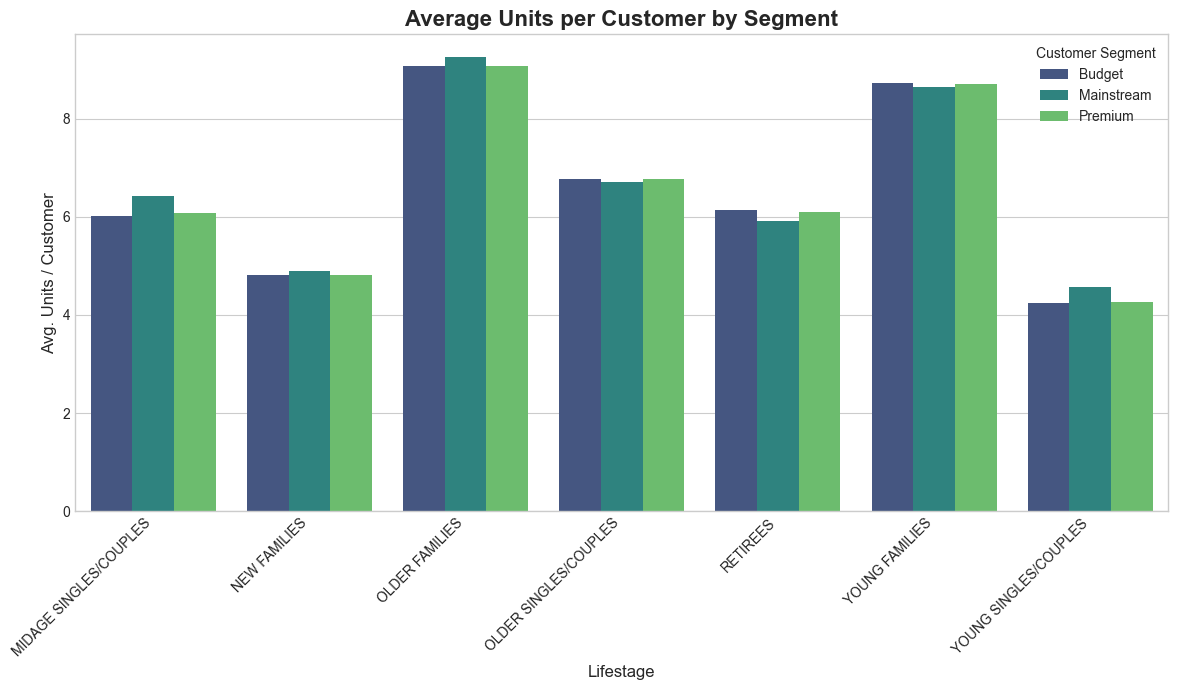

In [34]:
plt.figure(figsize=(12, 7))
sns.barplot(x='LIFESTAGE', y='AVG_UNITS_PER_CUSTOMER', hue='PREMIUM_CUSTOMER', data=avg_units_segment, palette='viridis', dodge=True)
plt.title('Average Units per Customer by Segment', fontsize=16, fontweight='bold')
plt.xlabel('Lifestage', fontsize=12)
plt.ylabel('Avg. Units / Customer', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Customer Segment')
plt.tight_layout()


In [35]:
avg_price_segment = merged_data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'], observed=True).agg(
    total_sales_val=('TOT_SALES', 'sum'),
    total_qty_val=('PROD_QTY', 'sum')
).reset_index()
avg_price_segment['AVG_PRICE_PER_UNIT'] = avg_price_segment['total_sales_val'] / avg_price_segment['total_qty_val']
print("--- Table 6: Average Price per Unit by Segment (Top 10) ---")
avg_price_segment.sort_values(by='AVG_PRICE_PER_UNIT', ascending=False).head(10)


--- Table 6: Average Price per Unit by Segment (Top 10) ---


,LIFESTAGE,PREMIUM_CUSTOMER,total_sales_val,total_qty_val,AVG_PRICE_PER_UNIT
19,YOUNG SINGLES/COUPLES,Mainstream,147582.20,36225,4.074043
1,MIDAGE SINGLES/COUPLES,Mainstream,84734.25,21213,3.994449
4,NEW FAMILIES,Mainstream,15979.70,4060,3.935887
12,RETIREES,Budget,105916.30,26932,3.932731
3,NEW FAMILIES,Budget,20607.45,5241,3.931969
14,RETIREES,Premium,91296.65,23266,3.924037
11,OLDER SINGLES/COUPLES,Premium,123537.55,31695,3.897698
9,OLDER SINGLES/COUPLES,Budget,127833.60,32883,3.887529
5,NEW FAMILIES,Premium,10760.80,2769,3.886168
13,RETIREES,Mainstream,145168.95,37677,3.852986


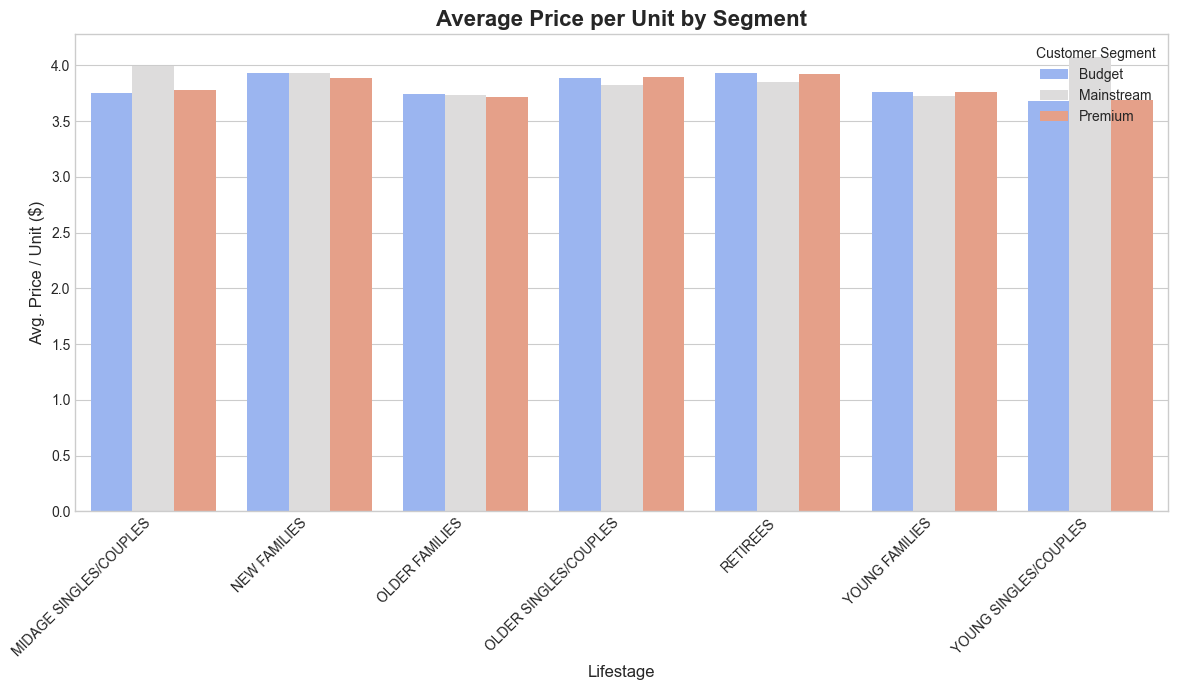

In [36]:
plt.figure(figsize=(12, 7))
sns.barplot(x='LIFESTAGE', y='AVG_PRICE_PER_UNIT', hue='PREMIUM_CUSTOMER', data=avg_price_segment, palette='coolwarm', dodge=True)
plt.title('Average Price per Unit by Segment', fontsize=16, fontweight='bold')
plt.xlabel('Lifestage', fontsize=12)
plt.ylabel('Avg. Price / Unit ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Customer Segment')
plt.tight_layout()


In [37]:
# Calculate price per unit for each transaction
merged_data['PRICE_PER_UNIT'] = merged_data['TOT_SALES'] / merged_data['PROD_QTY']

# Define groups for t-test
group_mainstream = merged_data[
    (merged_data['LIFESTAGE'].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"])) &
    (merged_data['PREMIUM_CUSTOMER'] == "Mainstream")
]['PRICE_PER_UNIT'].dropna()

group_other = merged_data[
    (merged_data['LIFESTAGE'].isin(["YOUNG SINGLES/COUPLES", "MIDAGE SINGLES/COUPLES"])) &
    (merged_data['PREMIUM_CUSTOMER'].isin(["Budget", "Premium"])) # Includes Budget and Premium
]['PRICE_PER_UNIT'].dropna()


In [38]:
if not group_mainstream.empty and not group_other.empty:
    t_stat, p_value = stats.ttest_ind(group_mainstream, group_other,
                                      equal_var=False, # Welch's t-test
                                      alternative='greater') # Test if mainstream is greater
    print("--- Table 7: T-test Results for Price Per Unit ---")
    print(f"Comparison: Mainstream (Young/Midage Singles/Couples) vs. Budget/Premium (Young/Midage Singles/Couples)")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4f}") # Format p-value for readability
    print(f"Avg Price (Mainstream): {group_mainstream.mean():.4f}")
    print(f"Avg Price (Budget/Premium): {group_other.mean():.4f}")
    if p_value < 0.05:
        print("Conclusion: There is statistical evidence that the Mainstream group pays a significantly higher price per unit.")
    else:
        print("Conclusion: There is not enough statistical evidence that the Mainstream group pays a significantly higher price per unit.")
else:
    print("Not enough data to perform T-test for the selected groups.")


--- Table 7: T-test Results for Price Per Unit ---
Comparison: Mainstream (Young/Midage Singles/Couples) vs. Budget/Premium (Young/Midage Singles/Couples)
T-statistic: 37.6244
P-value: 0.0000
Avg Price (Mainstream): 4.0398
Avg Price (Budget/Premium): 3.7065
Conclusion: There is statistical evidence that the Mainstream group pays a significantly higher price per unit.


In [39]:
print("--- Deep dive: Mainstream, Young Singles/Couples ---")
target_lifestage = "YOUNG SINGLES/COUPLES"
target_premium = "Mainstream"

# Filter target segment
segment1 = merged_data[
    (merged_data['LIFESTAGE'] == target_lifestage) &
    (merged_data['PREMIUM_CUSTOMER'] == target_premium)
].copy()

# Other segments (all customers not in target segment)
other_segments = merged_data[
    ~((merged_data['LIFESTAGE'] == target_lifestage) &
      (merged_data['PREMIUM_CUSTOMER'] == target_premium))
].copy()


--- Deep dive: Mainstream, Young Singles/Couples ---


In [40]:
if not segment1.empty and not other_segments.empty:
    # Calculate total quantity for each group
    quantity_segment1_total = segment1['PROD_QTY'].sum()
    quantity_other_total = other_segments['PROD_QTY'].sum()
    
    # Calculate proportion of each brand in total quantity
    quantity_segment1_by_brand = segment1.groupby('BRAND', observed=True)['PROD_QTY'].sum() / quantity_segment1_total
    quantity_other_by_brand = other_segments.groupby('BRAND', observed=True)['PROD_QTY'].sum() / quantity_other_total
    
    # Calculate brand affinity
    brand_affinity = pd.merge(
        quantity_segment1_by_brand.rename('targetSegment'),
        quantity_other_by_brand.rename('other'),
        on='BRAND', how='outer'
    ).fillna(0)
    brand_affinity['affinityToBrand'] = brand_affinity['targetSegment'] / brand_affinity['other']
    brand_affinity.replace([float('inf'), -float('inf')], pd.NA, inplace=True) # Handle division by zero
    brand_affinity.dropna(subset=['affinityToBrand'], inplace=True) # Remove NA due to division by zero
    
    print("--- Table 8: Brand Affinity of 'Mainstream, Young Singles/Couples' Segment (Top 10) ---")
    brand_affinity.sort_values(by='affinityToBrand', ascending=False).head(10)


--- Table 8: Brand Affinity of 'Mainstream, Young Singles/Couples' Segment (Top 10) ---


In [41]:
if not segment1.empty and not other_segments.empty:
    # Calculate proportion of each pack size in total quantity
    quantity_segment1_by_pack = segment1.groupby('PACK_SIZE')['PROD_QTY'].sum() / quantity_segment1_total
    quantity_other_by_pack = other_segments.groupby('PACK_SIZE')['PROD_QTY'].sum() / quantity_other_total
    
    # Calculate pack size affinity
    pack_affinity = pd.merge(
        quantity_segment1_by_pack.rename('targetSegment'),
        quantity_other_by_pack.rename('other'),
        on='PACK_SIZE', how='outer'
    ).fillna(0)
    pack_affinity['affinityToPack'] = pack_affinity['targetSegment'] / pack_affinity['other']
    pack_affinity.replace([float('inf'), -float('inf')], pd.NA, inplace=True)
    pack_affinity.dropna(subset=['affinityToPack'], inplace=True)
    
    print("--- Table 9: Pack Size Preference of 'Mainstream, Young Singles/Couples' Segment (Top 10) ---")
    pack_affinity.sort_values(by='affinityToPack', ascending=False).head(10)


--- Table 9: Pack Size Preference of 'Mainstream, Young Singles/Couples' Segment (Top 10) ---


In [42]:
if not segment1.empty and not other_segments.empty:
    # Investigate brands for high affinity pack size
    high_affinity_pack_size = 270 # Based on results from R documentation
    if high_affinity_pack_size in pack_affinity.index: # Check if pack size exists in affinity results
        brands_for_pack_size_270 = merged_data[merged_data['PACK_SIZE'] == high_affinity_pack_size]['BRAND'].unique()
        print(f"Products with {high_affinity_pack_size}g pack size: {', '.join(brands_for_pack_size_270)}")
    else:
        # Fallback if 270g is not the top, pick the actual top from calculation
        if not pack_affinity.empty:
            top_pack_size_from_py = pack_affinity.sort_values(by='affinityToPack', ascending=False).index[0]
            brands_for_top_pack_size = merged_data[merged_data['PACK_SIZE'] == top_pack_size_from_py]['BRAND'].unique()
            print(f"Products with highest affinity pack size ({top_pack_size_from_py}g): {', '.join(brands_for_top_pack_size)}")
else:
    print("Not enough data in segment1 or other_segments to perform deep dive analysis.")


Products with 270g pack size: TWISTIES
